# **Mount Colab to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Data**

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor: meningioma (708 slices),  glioma (1426 slices), and pituitary tumor (930 slices).


**Data Source:**

https://figshare.com/articles/brain_tumor_dataset/1512427 
Jun Cheng ( School of Biomedical Engineering,    Southern Medical University, Guangzhou, China)
           

       

# **Import Libaries**

In [ ]:

import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn-darkgrid")
import argparse
from argparse import ArgumentParser
import os
import sys
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use("seaborn-darkgrid")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnext50_32x4d
from torch.optim import Adam, AdamW, lr_scheduler

from tqdm import trange
import os
import albumentations as albu
import cv2
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnext50_32x4d
from torch.optim import Adam, AdamW, lr_scheduler
import numpy as np
from tqdm import trange
import os
import albumentations as albu
import cv2
import glob
from PIL import Image

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [ ]:
import sys
print(sys.path)


['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
pip install hdf5storage

     |████████████████████████████████| 61kB 7.5MB/s 


# **Download Data and Unzip Function**

In [ ]:
import urllib.request
import os
import re
from tqdm import tqdm
import zipfile
import hdf5storage


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, target_folder, filename):
    # check if data exists
    print("Check if data exists on disk")
    if not os.path.isdir(target_folder):
      print("Creating target folder")
      os.mkdir(target_folder)
    files = os.listdir(target_folder)
    if not files:
        print("Cannot find files on disk")
        print("Downloading files")
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url, filename=target_folder + filename, reporthook=t.update_to)
    print("Download completed!")

def unzip_all_files(target_folder):
    print("Unzip files")
    items = os.listdir(target_folder)
    while(any(item.endswith('.zip') for item in items)):
        for item in filter(lambda item: item.endswith('.zip'), items):
            with zipfile.ZipFile(target_folder + item, "r") as zip_ref:
                zip_ref.extractall(target_folder)
        for item in items:
            if item.endswith(".zip"):
                os.remove(target_folder + item)
        items = os.listdir(target_folder)
    print("Unzip completed!")

def convert_landmark_to_bounding_box(landmark):
    x_min = x_max = y_min = y_max = None
    for x, y in landmark:
        if x_min is None:
            x_min = x_max = x
            y_min = y_max = y
        else:
            x_min, x_max = min(x, x_min), max(x, x_max)
            y_min, y_max = min(y, y_min), max(y, y_max)
    return [int(x_min), int(x_max), int(y_min), int(y_max)]

def _arrange_brain_tumor_data(root):
    # Remove and split files
    items = [item for item in filter(lambda item: re.search("^[0-9]+\.mat$", item), os.listdir(root))]
    try:
        os.mkdir(root + 'meningioma/')
    except:
        print("Meningioma directory already exists")
    try:
        os.mkdir(root + 'glioma/')
    except:
      print("Glioma directory already exists")
    try:
        os.mkdir(root + 'pituitary/')
    except:
        print("Pituitary directory already exists")

    for item in items:
        sample = hdf5storage.loadmat(root + item)['cjdata'][0]
        if sample[2].shape[0] == 512:
            if sample[0] == 1:
                os.rename(root + item, root + 'meningioma/' + item)
            if sample[0] == 2:
                os.rename(root + item, root + 'glioma/' + item)
            if sample[0] == 3:
                os.rename(root + item, root + 'pituitary/' + item)
        else:
            os.remove(root + item)

def get_data_if_needed(data_path='./data/', url="https://ndownloader.figshare.com/articles/1512427/versions/5"):
    if os.path.isdir(data_path):
        print("Data directory already exists. ",
              "if from some reason the data directory structure is wrong please remove the data dir and rerun this script")
        return
    filename = "all_data.zip"
    download_url(url, data_path, filename)
    unzip_all_files(data_path)
    _arrange_brain_tumor_data(data_path)

# **DataTumorDataset Class**

Data Transformation of  .mat file to  with diffrent attributes (masks, labels, image, bounding box, landmarks)  in to three diffrent folders: glioma, pituitary, miningioma.

A single .mat file consists of:

PID: Patient ID for that particular tumor image. 

image: Image of the brain tumor

label: Label between 1-3 denoting what kind of tumor is present

tumorBorder: Coordinates of the tumor present in the image

tumorMask: Masked version of the tumor.

We'll need the image, label, tumorBorder, tumorMask which are the necessary features that'll help us to detect brain tumors.

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import ToPILImage
import os
import math
import hdf5storage
from enum import Enum


class ClassesLabels(Enum):
    Meningioma = 1
    Glioma = 2
    Pituitary = 3

    def __len__(self):
        return 3


class BrainTumorDataset(Dataset):
    """
     REadME File for the Data Used:   This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
        from 233 patients with three kinds of brain tumor: meningioma (708 slices),
        glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size
        limit of repository, we split the whole dataset into 4 subsets, and achive
        them in 4 .zip files with each .zip file containing 766 slices.The 5-fold
        cross-validation indices are also provided.
        -----
            The brain Tumor data is organized in matlab data format (.mat file). Each file stores a struct
            containing the following fields for an image:
            label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
            PID: patient ID
            image: image data
            tumorBorder: a vector storing the coordinates of discrete points on tumor border.
                    For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
                    It was generated by manually delineating the tumor border. So we can use it to generate
                    binary image of tumor mask.
            tumorMask: a binary image with 1s indicating tumor region
        -----
        taken from https://figshare.com/articles/brain_tumor_dataset/1512427 all right reserved to
            Jun Cheng
            School of Biomedical Engineering
            Southern Medical University, Guangzhou, China
            Email: chengjun583@qq.com
        -----
    """

    def __init__(self, root, train=True, download=True,
                                                  classes=(ClassesLabels.Meningioma,
                                                  ClassesLabels.Glioma,
                                                  ClassesLabels.Pituitary)):
        super().__init__()
        test_fr = 0.15
        if download:
            get_data_if_needed(root)
        self.root = root
        # List all data files
        items = []
        if ClassesLabels.Meningioma in classes:
            items += ['meningioma/' + item for item in os.listdir(root + 'meningioma/')]
        if ClassesLabels.Glioma in classes:
            items += ['glioma/' + item for item in os.listdir(root + 'glioma/')]
        if ClassesLabels.Meningioma in classes:
            items += ['pituitary/' + item for item in os.listdir(root + 'pituitary/')]

        if train:
            self.items = items[0:math.floor((1-test_fr) * len(items)) + 1]
        else:
            self.items = items[math.floor((1-test_fr) * len(items)) + 1:]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        """
        Get the data item
            label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
            PID: patient ID
            image: image data
            tumorBorder: a vector storing the coordinates of discrete points on tumor border.
                    For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
                    It was generated by manually delineating the tumor border. So we can use it to generate
                    binary image of tumor mask.
            tumorMask: a binary image with 1s indicating tumor region
            And convert it to more convenient python dict object
        :param idx: index of item between 0 to len(self.item) - 1
        :return: dict - {label: int, image: matrix, landmarks: array of tuple (x, y), mask: matrix, bounding_box 4 size array of (x, y)}
        """
        if not (0 <= idx <  len(self.items)):
            raise IndexError("Idx out of bound")

        data = hdf5storage.loadmat(self.root + self.items[idx])['cjdata'][0]
        # transform the tumor border to array of (x, y) tuple
        xy = data[3]
        landmarks = []
        for i in range(0, len(xy), 2):
            x = xy[i][0]
            y = xy[i + 1][0]
            landmarks.append((x, y))
        mask = data[4]
        data[2].dtype = 'uint16'
        image_with_metadata = {
            "label": int(data[0][0]),
            "image": ToPILImage()(data[2]),
            "landmarks": landmarks,
            "mask": mask,
            "bounding_box": convert_landmark_to_bounding_box(landmarks)
        }
        return image_with_metadata


class BrainTumorDatasetMask(BrainTumorDataset):
    def __init__(self, root, train=True, transform=None, classes=(ClassesLabels.Meningioma,
                                                  ClassesLabels.Glioma,
                                                  ClassesLabels.Pituitary)):
        super().__init__(root, train, classes=classes)
        self.transform = transform

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        sample = (item["image"], item["mask"])
        return sample if self.transform is None else self.transform(*sample)

class BrainTumorDatasetMaskAndBoundingBox(BrainTumorDataset):
    def __init__(self, root, train=True, transform=None, classes=(ClassesLabels.Meningioma,
                                                  ClassesLabels.Glioma,
                                                  ClassesLabels.Pituitary)):
        super().__init__(root, train, classes=classes)
        self.transform = transform

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        sample = (item["image"], item["mask"], item['bounding_box'])
        return sample if self.transform is None else self.transform(*sample)

# **Image Visualization Function**

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

# **Image Preprocessing Function**

For image transformation

In [ ]:
def preprocessing(image, mask):
    image_transformer = transforms.Compose([
        transforms.Resize((128,128), interpolation=0),
        transforms.ToTensor()
    ])
    mask_transformer = transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(transforms.ToTensor()(x).float().squeeze())),
        image_transformer
    ])
    return image_transformer(image).float(), mask_transformer(mask).float()


# **Download Data**

In [ ]:
# Download and load data
url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
filename = "all_data.zip"
target_folder = '/content/drive/My Drive/Project/data2/'
_arrange_brain_tumor_data('/content/drive/My Drive/Project/data2/')


# **Data Coverting .mat file to numpy**

In [ ]:
"""
Read all the Matlab files in the 'data' directory and export 3 numpy arrays:
- labels.npy
- images.npy
- masks.npy

"""

import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import easydict

class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')

    if os.path.isdir(data_path):
        return path
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)



args = easydict.EasyDict({
    "path": path,
    "image_dimension": 512
})


labels = []
images = []
masks = []


data_dir = os.path.join(args.path, 'data').replace('\\', '/')
files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(args.image_dimension, args.image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(args.image_dimension, args.image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(args.path, 'labels.npy'), labels)
np.save(os.path.join(args.path, 'images.npy'), images)
np.save(os.path.join(args.path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', args.path)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in 1512427


# **Load Data**

In [ ]:
data_images = np.load('/content/drive/My Drive/Project/images.npy', allow_pickle=True)
data_labels = np.load('/content/drive/My Drive/Project/labels.npy', allow_pickle=True)
data_masks = np.load('/content/drive/My Drive/Project/masks.npy', allow_pickle=True)
print(" Shapes:\n Images:",data_images.shape, "Masks:", data_masks.shape, "Labels:", data_labels.shape)

 Shapes:
 Images: (3064, 512, 512) Masks: (3064, 512, 512) Labels: (3064,)


# **Example from Images Class**

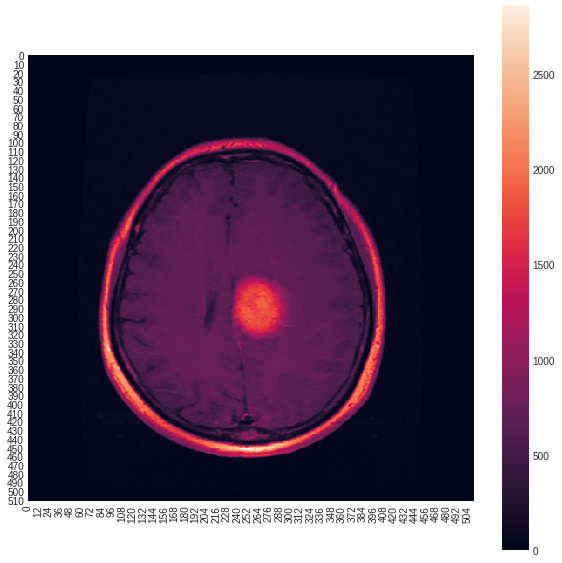

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(data_images[1], square=True)
plt.show()

# **Ground Truth Mask of the correspondig Image**

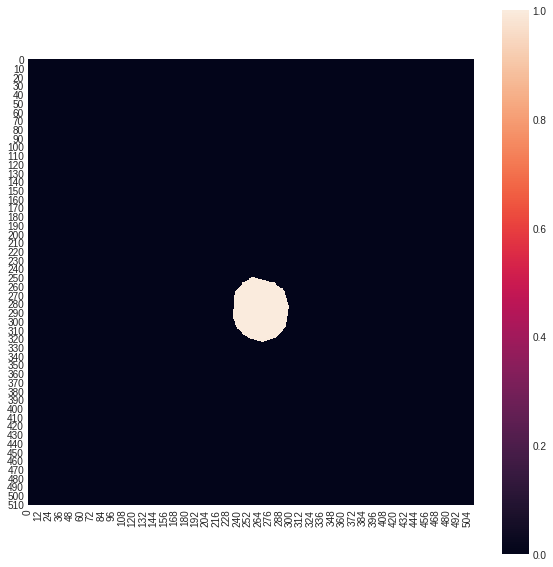

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(data_masks[1], square=True)
plt.show()

# **Data Class Distribution**

Number of Meningioma tumors: 708 
Number of Glioma tumors: 1426 
Number of Pituitary tumor tumors: 930 


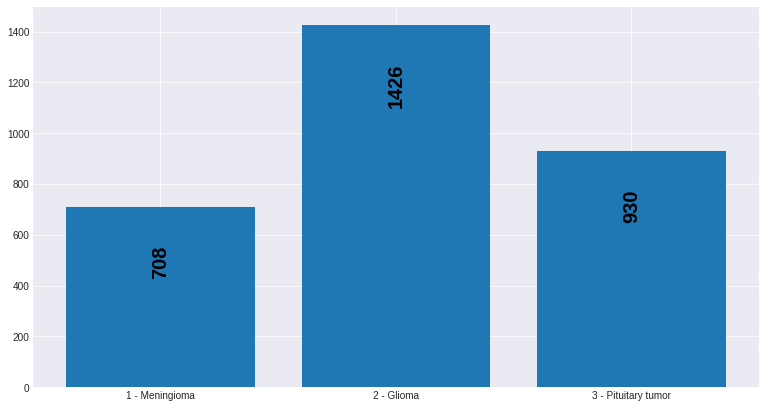

In [ ]:
plt.figure(figsize=(13, 7))
class_labels = {'1': 'Meningioma', '2': 'Glioma', '3': 'Pituitary tumor'}
classes, counts = np.unique(data_labels, return_counts=True)

plt.bar(classes, counts,
        tick_label=['1 - Meningioma', '2 - Glioma', '3 - Pituitary tumor'])

for i, idx in enumerate(classes):
    print('Number of {} tumors: {} '.format(class_labels[str(idx)], counts[i]))

    labels=[1,2,3]   
for label, count in zip(labels,counts):

    plt.annotate(int(count), xy=(label, count-150), 
                rotation=90, color='black', 
                ha="center", verticalalignment='top', 
                fontsize=20, fontweight="bold")

# **Samples of Images and Masks From Each Class**

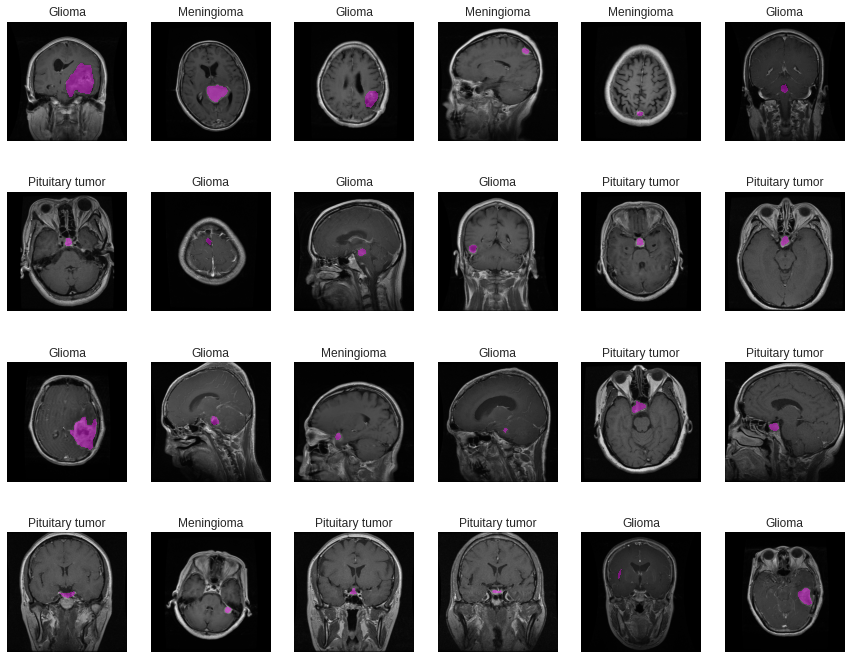

In [ ]:
plt.figure(figsize=(15, 12))
for i, idx in enumerate(np.random.randint(data_images.shape[0], size=24), start=1):
    #plot the MRI image
    plt.subplot(4, 6, i)
    plt.imshow(data_images[idx], cmap='gray')
    
    #plot the mask
    mask = np.ma.masked_where(data_masks[idx] == False, data_masks[idx])
    plt.imshow(mask, alpha=0.4, cmap='spring')
    
    plt.title(class_labels[str(data_labels[idx])])
    plt.axis('off')

# **Image Bounding Box Function**

In [ ]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox
    
    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])
    
    return image[y1:y2, x1:x2]

# **Image Crop**

In [ ]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(data_images.shape[0]):
    if i % 10 == 0:
        # print the percentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, data_images.shape[0], (i+1) / data_images.shape[0] * 100))
        
    bbox = get_bounding_box(data_masks[i])
    image = crop_to_bbox(data_images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)
    
clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, data_images.shape[0], (i+1) / data_images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [ ]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

# **Visualization of Cropped Image Bounding Box**

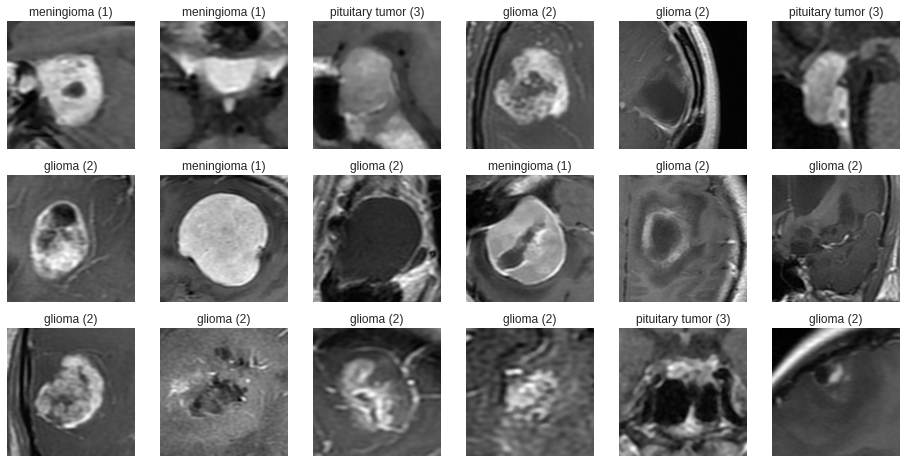

In [ ]:

plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(data_images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(data_labels[idx])])
    plt.axis('off')

Create New Folders:

new_dataset

images

In [ ]:
os.mkdir('/content/drive/My Drive/Project/new_dataset')

In [ ]:

os.mkdir('/content/drive/My Drive/Project/new_dataset/images')

Create empty lists for storing labels and border

In [ ]:

labels = []
border = []

Save images of brain tumor, masks and store labels and borders in their respective lists iteratively.

3064 files successfully saved


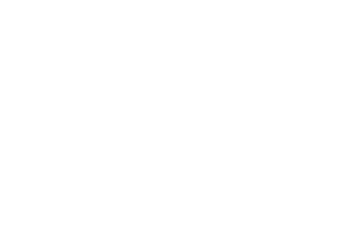

In [ ]:
filename = None

for filename in range(1, 3065):
  with h5py.File('/content/drive/My Drive/Project/data/{}.mat'.format(filename), 'r') as f:
      img = f['cjdata']['image']
      label = f['cjdata']['label'][0][0]
      coord = f['cjdata']['tumorBorder'][0]
     
     
      labels.append(int(label))
      
      border.append(coord)
      img = np.array(img, dtype=np.float32)
      
      plt.axis('off')
      plt.imsave("/content/drive/My Drive/Project/new_dataset/images/{}.jpg".format(filename), img, cmap='gray')
      
      
print("{} files successfully saved".format(filename))

In [ ]:
os.mkdir('/content/drive/My Drive/Project/new_dataset/labels')

# **Create Label Pickle File**

Store the labels and tumor border (coordinates) as a pickle file, which can be loaded whenever we want to use it.

In [ ]:
#Convert the Python lists to a Numpy arrays
label_names = np.array(labels, dtype=np.int64)

pickle_out = open("/content/drive/My Drive/Project/new_dataset/labels.pickle","wb")                    
pickle.dump(label_names, pickle_out)
pickle_out.close()

Create an empty list named 'training_data' in which we'll store our images and their respective labels as arrays

In [ ]:
training_data = []
img = None
label = None
i = None

# **Create Training Data Pickle file**

Read the images from  and convert it to RGB images and store it along with their respective labels in the training_data list.

In [ ]:
for i in range(1, 3065):
  img = cv2.imread("/content/drive/My Drive/Project/new_dataset/images/{}.jpg".format(i), cv2.IMREAD_GRAYSCALE)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = cv2.resize(img, (512, 512))
  label = label_names[i-1]
  training_data.append([img, label])

print("shape: {} label: {} | {} samples successfully preprocessed".format(img.shape, label, i))

pickle_out = open("/content/drive/My Drive/Project/new_dataset/training_data.pickle","wb")                    
pickle.dump(training_data, pickle_out)
pickle_out.close()

shape: (512, 512, 3) label: 1 | 3064 samples successfully preprocessed


# **Data Transformation and Visualization**

Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script
Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script


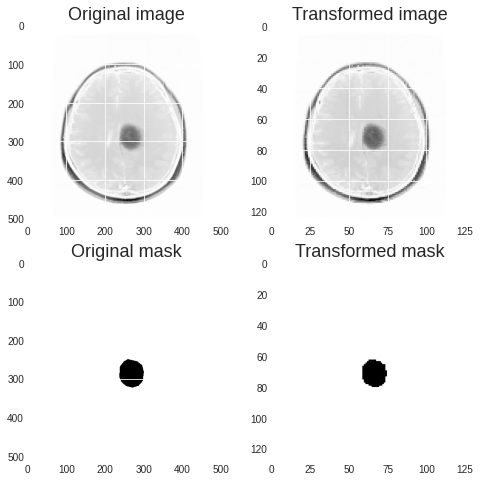

In [ ]:
dataset = BrainTumorDatasetMask(root=target_folder,train=True)
original_image , original_mask = dataset[1]
dataset_after_transformation = BrainTumorDatasetMask(root=target_folder,train=True, transform=preprocessing)
image, mask = dataset_after_transformation[1]
visualize(image.squeeze(), mask.squeeze(), original_image, original_mask)

# **Calculate Image Mean**

In [ ]:
# calculate the mean of the images
loader = DataLoader(
    dataset_after_transformation,
    batch_size=10,
    num_workers=1,
    shuffle=False
)
mean = 0.
std = 0.
nb_samples = 0.
for images, masks in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples
    
mean /= nb_samples
std /= nb_samples
print(mean)
print(std)

tensor([490.6375])
tensor([558.9124])


# **Normalization Function**

In [ ]:
def normalize(x, mean=470., std=None):
    mean_tansor = torch.ones_like(x) * mean
    x = x - mean_tansor
    x = x.long()
    if std:
        x /= std
    return x

def denormalize(x, mean=455.635, std=None):
    mean_tansor = torch.ones_like(x) * mean
    x += mean_tansor
    if std:
        x *= std
    return x


def preprocessing(image, mask):
    mask_transformer = transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(transforms.ToTensor()(x).float().squeeze())),
        transforms.Resize((256,256), interpolation=0),
        transforms.ToTensor()    
    ])
    image_transformer = transforms.Compose([
        transforms.Resize((256,256), interpolation=0),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: normalize(x))
    ])
    return image_transformer(image).float(), mask_transformer(mask).float()

# **Data Transformation , Normalization and Visualization**

Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script


2592

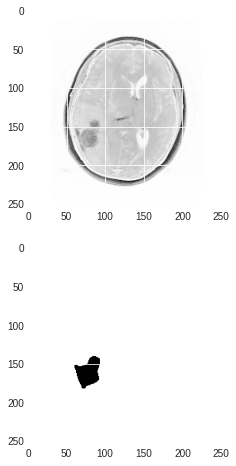

In [ ]:
dataset = BrainTumorDatasetMask(root=target_folder,train=True, transform=preprocessing)
image, mask = dataset[6]
visualize(denormalize(image).squeeze(), mask.squeeze())
len(dataset)

In [ ]:
import os
import re
import hdf5storage

root='/content/drive/My Drive/Project/data2/'
items = [item for item in filter(lambda item: re.search("^[0-9]+\.mat$", item), os.listdir(root))]
# Remove files and split files
filtered_items = []
try:
    os.mkdir(root + 'meningioma/')
    os.mkdir(root + 'glioma/')
    os.mkdir(root + 'pituitary/')
except:
    print("Dirs already exists")

for item in items:
    sample = hdf5storage.loadmat(root + item)['cjdata'][0]
    if sample[2].shape[0] == 512:
        if sample[0] == 1:
            os.rename(root + item, root + 'meningioma/' + item)
        if sample[0] == 2:
            os.rename(root + item, root + 'glioma/' + item)
        if sample[0] == 3:
            os.rename(root + item, root + 'pituitary/' + item)
    else:
        os.remove(root + item)

Dirs already exists
